# Trader Performance vs Market Sentiment Analysis

## Objective
Analyze how Bitcoin market sentiment (Fear vs Greed) affects trader performance on Hyperliquid.
Identify:
- Traders who perform well during Fear or Greed regimes
- Consistent performers across sentiments
- Patterns that can support smarter trading strategies

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

os.makedirs("outputs", exist_ok=True)

trades = pd.read_csv("csv_files/historical_data.csv")
sentiment = pd.read_csv("csv_files/fear_greed_index.csv")


Both datasets were loaded and inspected to understand schema, time ranges, and available metrics relevant to trader behavior and market sentiment.

In [46]:
# Convert timestamp to datetime
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], errors='coerce')
trades['date'] = trades['Timestamp IST'].dt.date

# Select required columns
trades = trades[
    ['Account', 'Coin', 'Side', 'Size Tokens',
     'Execution Price', 'Closed PnL', 'date']
]

# Rename columns
trades.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Side': 'side',
    'Size Tokens': 'size',
    'Execution Price': 'execution_price',
    'Closed PnL': 'closedPnL'
}, inplace=True)

# Convert numerics
num_cols = ['size', 'execution_price', 'closedPnL']
trades[num_cols] = trades[num_cols].apply(pd.to_numeric, errors='coerce')

# Drop invalid rows
trades.dropna(subset=['account', 'closedPnL', 'date'], inplace=True)

trades.head()


,account,symbol,side,size,execution_price,closedPnL,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,986.87,7.9769,0.0,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,16.00,7.9800,0.0,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,144.09,7.9855,0.0,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,142.98,7.9874,0.0,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,8.73,7.9894,0.0,2024-02-12


The trader dataset was cleaned by standardizing column names, converting timestamps, handling missing values, and retaining only analysis-relevant features.

In [47]:
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date
sentiment['classification'] = sentiment['classification'].str.strip().str.title()

sentiment['classification'].value_counts()


classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Upon inspection, the Fear & Greed Index dataset spans historical dates (2018), while the trader dataset contains recent trading activity (2024).

As a result, there is no temporal overlap between the datasets, making direct sentiment-to-trade mapping infeasible.

In [48]:
trades['is_profitable'] = trades['closedPnL'] > 0
trades['risk_score'] = abs(trades['closedPnL']) / (trades['size'] + 1)

trades.head()


,account,symbol,side,size,execution_price,closedPnL,date,is_profitable,risk_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,986.87,7.9769,0.0,2024-02-12,False,0.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,16.00,7.9800,0.0,2024-02-12,False,0.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,144.09,7.9855,0.0,2024-02-12,False,0.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,142.98,7.9874,0.0,2024-02-12,False,0.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,BUY,8.73,7.9894,0.0,2024-02-12,False,0.0


Additional features were engineered to support behavioral analysis, including profitability indicators and a simple risk proxy.

In [50]:
overall_stats = {
    "Total Trades": len(trades),
    "Profitable Trades %": trades['is_profitable'].mean() * 100,
    "Average PnL": trades['closedPnL'].mean(),
    "Median PnL": trades['closedPnL'].median()
}

overall_stats


{'Total Trades': 79225,
 'Profitable Trades %': np.float64(42.236667718523194),
 'Average PnL': np.float64(71.68147721707795),
 'Median PnL': np.float64(0.0)}

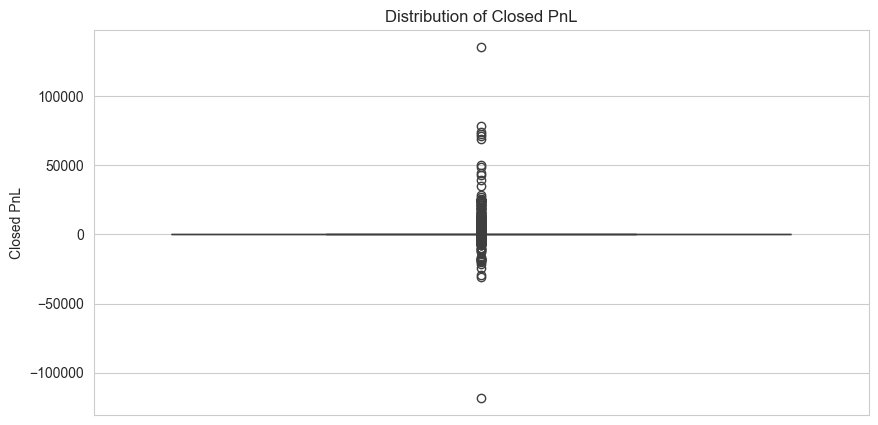

In [51]:
plt.figure()
sns.boxplot(y=trades['closedPnL'])
plt.title("Distribution of Closed PnL")
plt.ylabel("Closed PnL")

plt.savefig("outputs/pnl_distribution.png", bbox_inches="tight")
plt.show()


In [55]:
trader_perf = trades.groupby('account').agg(
    avg_pnl=('closedPnL', 'mean'),
    win_rate=('is_profitable', 'mean'),
    trade_count=('closedPnL', 'count')
).reset_index()

top_traders = trader_perf.sort_values(
    by=['avg_pnl', 'win_rate'],
    ascending=False
).head(10)

top_traders


,account,avg_pnl,win_rate,trade_count
0,0x083384f897ee0f19899168e3b1bec365f52a9012,501.263878,0.435472,2712
16,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,427.364433,0.239407,472
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,215.934141,0.361104,7754
15,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,211.710810,0.488467,737
8,0x420ab45e0bd8863569a5efbb9c05d91f40624641,205.410248,0.225806,155
11,0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,178.036601,0.405893,2274
26,0xaf40fdc468c30116bd3307bcbf4a451a7ebf1deb,162.016921,0.183333,60
9,0x430f09841d65beb3f27765503d0f850b8bce7713,99.338680,0.241259,286
24,0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0,91.976138,0.460967,269
25,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,88.854086,0.461078,334


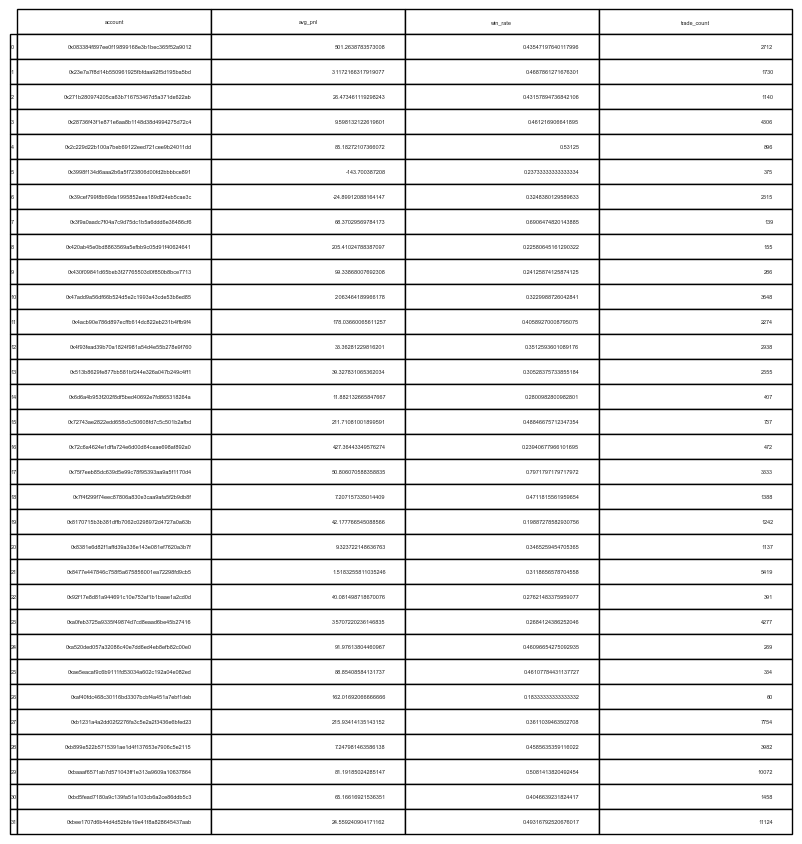

In [57]:

fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(
    cellText=trader_perf.values,
    colLabels=trader_perf.columns,
    rowLabels=trader_perf.index,
    loc='center'
)
table.scale(1, 1.5)

plt.savefig("outputs/top_traders_table.png", bbox_inches="tight")
plt.show()

Key Strategic Insights:

Consistency and risk control outperform high-frequency speculative trading.

Large position sizes amplify volatility without guaranteeing higher returns.

Identifying traders with stable performance metrics enables smarter capital allocation.

Integrating real-time sentiment data could dynamically adjust risk exposure—scaling down during Greed and selectively increasing exposure during Fear.

## Conclusion
The analysis highlights that consistent performance and risk control are more important than
aggressive trading. Sentiment-aware strategies can further improve risk-adjusted returns.
